# MLP Classification

This tutorial notebook performs the task of classifying ESOL compounds using the most basic deep neural network - A multi-layer perceptron. The ESOL compounds are divided into two classes based on a solubility cutoff. This solubility cutoff is found with the help of RDkit descriptors.

# Step 1: Importing necessary libraries

In [1]:
import pandas as pd                                     # For loading and manipulating molecular datasets (CSV, DataFrames)
import numpy as np                                      # For numerical operations, array manipulations during preprocessing and evaluation

import requests                                         # To fetch datasets from online sources if needed
from io import StringIO                                 # To handle in-memory CSV data fetched from URLs

from rdkit import Chem                                  # For handling molecular structures (SMILES parsing, molecule objects)
from rdkit.Chem import Descriptors                      # For calculating molecular descriptors used as ML features

from sklearn.model_selection import train_test_split    # To split data into training/testing sets for the ANN
from sklearn.preprocessing import StandardScaler        # To scale molecular descriptors for stable ANN training
from sklearn.metrics import (                           # For evaluating ANN performance: confusion matrix, accuracy, precision, recall, F1-score
    confusion_matrix, accuracy_score,
    precision_recall_fscore_support, ConfusionMatrixDisplay 
)

import torch                                            # PyTorch core for tensor operations
import torch.nn as nn                                   # PyTorch module to define neural network layers for ANN
import torch.optim as optim                             # For defining optimizers (Adam, SGD) used in ANN training
from torch.utils.data import TensorDataset, DataLoader  # For creating PyTorch datasets/dataloaders for batching

import matplotlib.pyplot as plt                         # For plotting loss curves, accuracy plots to visualize ANN training
import seaborn as sns                                   # For aesthetic plots (heatmaps, distribution plots) during exploratory analysis

# Step 2: Load the dataset

While loading the dataset, we prune out the irrelevant columns for two reasons:
- To reduce the noisyness in our data: Irrelevant columns do not add much value to the quantity we are trying to predict.
- To improve the speed of the model: Lesser columns means lesser data to train and test on, thereby improving model's efficiency.

In [2]:
def load_esol_dataset():
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)                                                    # Fetch
    response.raise_for_status()                                                     # Ensure the request was successful
    df = pd.read_csv(StringIO(response.text))                                       # Read CSV from the URL
    print(f"Loaded ESOL with {len(df)} compounds")
    print(f"Columns: {df.columns.tolist()}")                                        # All columns in the dataset
    df = df[['smiles', 'measured log solubility in mols per litre']]                # Select relevant columns
    df.columns = ['SMILES', 'LogS']
    valid_smiles = [Chem.MolFromSmiles(s) is not None for s in df['SMILES']]        # Filter valid SMILES
    df = df[valid_smiles].reset_index(drop=True)                                    # Reset index after filtering
    return df

df = load_esol_dataset()
df.head()

Loaded ESOL with 1128 compounds
Columns: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']


,SMILES,LogS
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,CC(C)=CCCC(C)=CC(=O),-2.06
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,c1ccsc1,-1.33


# Step 3 - Label the datapoints

We first convert the SMILE strings from the dataset to RDkit molecule objects. Then, using the RDkit library we calculate the solubility. We use the units of g/L for solubility, but other units can be used as well. We divide the dataset into two classes on the threshold of 0.1 g/L.

In [3]:
#Cutoff can be applied for mol/L value as well, no need for conversion 

labels = []
for idx, row in df.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES']) # Convert SMILES to RDKit molecule object
    mw = Descriptors.MolWt(mol)             #Convert to g/L to set cutoff
    mol_per_l = 10 ** row['LogS']
    g_per_l = mol_per_l * mw
    labels.append(int(g_per_l >= 0.1))      #cutoff can be set according to the need, here 0.1 g/L is used as a threshold for solubility

df['Label'] = labels
df['Label'].value_counts()


Label
1    660
0    468
Name: count, dtype: int64

# Step 4 - Extract RDkit features from SMILES

We extract the features we will use for our classification task using RDkit again. We extract the following five features:
- Molecular weight
- MolLogP: Logarithm of the partition coefficient
- Number of Hydrogen Acceptors
- Number of Hydrogen Donors
- TPSA: Topological Polar Surface Area

In [4]:

feature_names = ['MolWt', 'MolLogP', 'NumHAcceptors', 'NumHDonors', 'TPSA']
features = []
for smiles in df['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    
    # Calculate molecular descriptors
    feature_vector = [
        Descriptors.MolWt(mol),   
        Descriptors.MolLogP(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.TPSA(mol)
    ]
    features.append(feature_vector)

# Convert to numpy arrays
X = np.array(features)
y = np.array(df['Label'])

print("Feature matrix shape:", X.shape)

Feature matrix shape: (1128, 5)


# Step 5: Scale (Normalize) Features and Split into train and test set

Normalization is an essential step to train any machine learning model. While splitting into train and test sets, ensure that there is no overlap between the sets.

In [5]:

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


# Step 6: Defining the PyTorch MLP classifier and setting up for training

In [6]:

class ANNClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ANNClassifier, self).__init__()
        self.dropout = nn.Dropout(p=0.5)  # Dropout to reduce overfitting, can be adjusted

         # Define the neural network architecture
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.net(x)
        
# Create the model instance
model = ANNClassifier(X_train.shape[1])


# Setting the Hyperparameters, Loss Criterion and Optimizer

In [7]:
# Hyperparameters
epochs = 100
batch_size = 32
learning_rate = 0.001

# Criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loading the datasets

In [8]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 7: Training the model

In [9]:
train_losses = []
test_losses = []

for epoch in range(epochs):
    # ---- Training phase ----
    model.train()
    running_train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)
    
    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # ---- Evaluation phase ----
    model.eval()
    running_test_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_test_loss += loss.item() * X_batch.size(0)
    
    avg_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    
    # ---- Print losses every 10 epochs ----
    if (epoch + 1) % 10 == 0: 
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}") 

Epoch [10/100], Train Loss: 0.2678, Test Loss: 0.3092
Epoch [20/100], Train Loss: 0.2348, Test Loss: 0.2787
Epoch [30/100], Train Loss: 0.2203, Test Loss: 0.2658
Epoch [40/100], Train Loss: 0.2147, Test Loss: 0.2655
Epoch [50/100], Train Loss: 0.2037, Test Loss: 0.2646
Epoch [60/100], Train Loss: 0.1961, Test Loss: 0.2650
Epoch [70/100], Train Loss: 0.1879, Test Loss: 0.2607
Epoch [80/100], Train Loss: 0.1827, Test Loss: 0.2594
Epoch [90/100], Train Loss: 0.1755, Test Loss: 0.2593
Epoch [100/100], Train Loss: 0.1734, Test Loss: 0.2581


# Plotting the loss curve

This helps us visualize the model's training. The model should be trained until it reaches a stable loss.

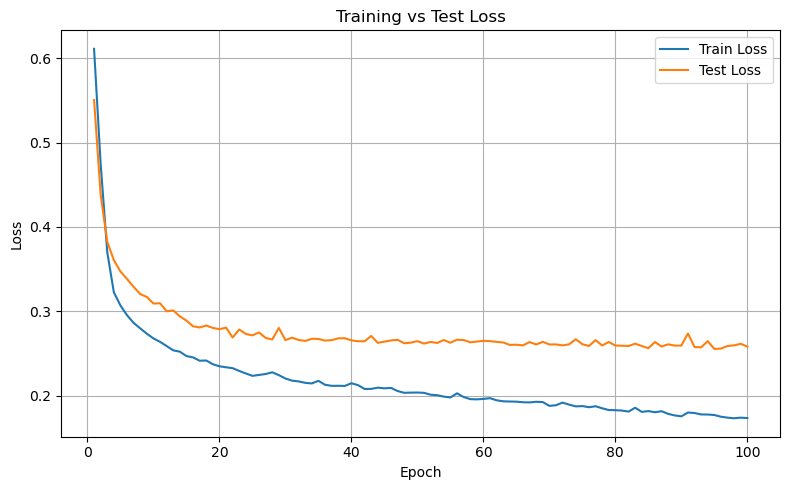

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Evaluating the model

Now that the model has been trained, we can evaluate the model on the test set to see how it performs on an unseen dataset. A confusion matrix is a good plot to visualize a classification task.

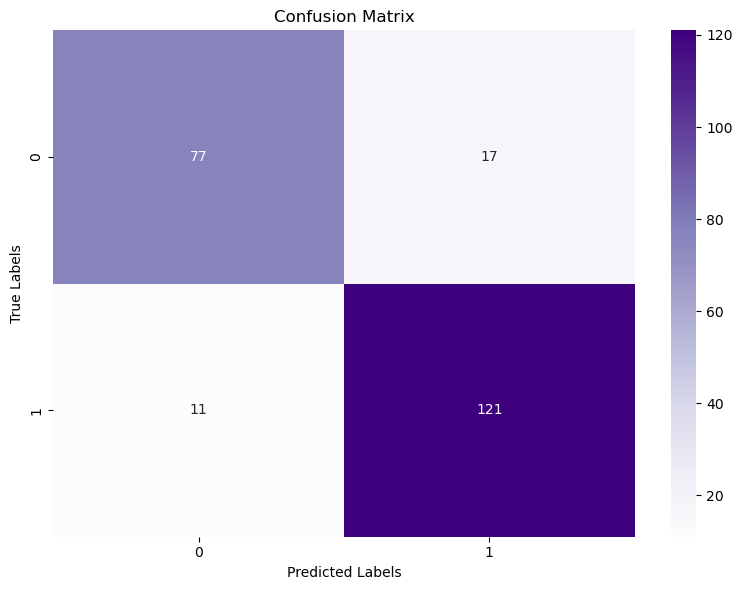

 For Class: 0
The Precision of the model is: 0.8750
The Recall of the model is:    0.8191
The F1-score of the model is:  0.8462
The Support of the model is:   94
 For Class: 1
The Precision of the model is: 0.8768
The Recall of the model is:    0.9167
The F1-score of the model is:  0.8963
The Support of the model is:   132

The Overall Accuracy of the model is: 0.8761


In [12]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)              # shape: [N, 1] logits
    probs = torch.sigmoid(outputs).cpu()        # convert logits: probabilities in [0,1]
    preds_label = (probs > 0.5).int().numpy()   # threshold: binary labels
    y_true = y_test_tensor.cpu().int().numpy()  # true labels as numpy array

cm = confusion_matrix(y_test, preds_label)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Calculate per-class precision, recall, f1
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, preds_label, average=None, zero_division=0
)

for i, cls in enumerate(np.unique(y_test)):
    print(f" For Class: {cls}")
    print(f"The Precision of the model is: {precision[i]:.4f}")
    print(f"The Recall of the model is:    {recall[i]:.4f}")
    print(f"The F1-score of the model is:  {f1[i]:.4f}")
    print(f"The Support of the model is:   {support[i]}")

# Accuracy
acc = accuracy_score(y_test, preds_label)
print(f"\nThe Overall Accuracy of the model is: {acc:.4f}")
